## KQ3: Pritts Meta-analysis Update

In key question 3, we address the risk of sarcoma dissemination following morcellation of fibroids. We identified a recently published analysis conducted by Elizabeth Pritts and her colleagues (2015) to estimate the  prevalence of occult leiomyosarcoma at time of treatment for presumed benign tumors (fibroids).  We updated their search and used similar eligibility criteria to identify papers published since 2014. We extracted from these papers the number of women who were treated for uterine fibroids and the cases of leiomyosarcoma subsequently identified.  We have combined these data with the data from the 134 publications that Pritts et al included in their analysis for a total of LMS rates from 148 sources.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

rseeds = 20090425, 19771114, 20161216, 19700903

In [2]:
keep_cols = ['Author', 'Year', 'Design', 'Procedure', 'Indication',
                                     'Age, Mean', 'Age, SD', 'Age, Median', 'Age, Min', 'Age, Max', 'Age, Other',
                                     'LMS','Population','Tumors','InPritts','POSTOP_HP_Done', 'Hysteroscopy']

datasets = pd.read_excel('data/Pritts_EPC_KQ3_Includes_Histopathology_SK_03212017.xlsx', 
                         sheetname=['OLD_PRITTS', 'UPDATED_PRITTS', 'Updated_Pritts_With_EPC_INclude'], 
                         na_values=['NR', 'NA'],
                        index_col=0)

In [3]:
def clean_data(kq3_data):

    return (kq3_data.assign(age_max=kq3_data['Age, Max'].replace('50+', 50),
                           design=kq3_data['Design'].str.strip().replace('prospective', 'Prospective'),
                           Prospective=(kq3_data.Design!='Retrospective').astype(int))
                    .rename(columns={'Age, Min': 'age_min',
                                       'Age, Mean': 'age_mean',
                                       'Age, SD': 'age_sd',
                                       'Age, Median': 'age_med'})
                    .drop(['Age, Max', 'Design'], axis=1)
                    .dropna(thresh=7))
    

In [4]:
datasets = {sheet: clean_data(datasets[sheet][keep_cols]) for sheet in datasets}

old_pritts = datasets['OLD_PRITTS']
updated_pritts = datasets['UPDATED_PRITTS']
all_data = datasets['Updated_Pritts_With_EPC_INclude']

Missing values

In [5]:
all_data.isnull().sum()

Author              0
Year                0
Procedure           0
Indication          1
age_mean           71
age_sd            149
age_med           150
age_min            64
Age, Other        127
LMS                 0
Population          0
Tumors              0
InPritts            0
POSTOP_HP_Done      0
Hysteroscopy        0
Prospective         0
age_max            65
design              0
dtype: int64

In [6]:
all_data.describe()

,Year,age_mean,age_sd,age_med,age_min,LMS,Population,Tumors,InPritts,Prospective,age_max
count,161.000000,90.000000,12.000000,11.000000,97.00000,161.000000,161.000000,161.000000,161.000000,161.000000,96.000000
mean,2005.155280,41.919222,7.009167,41.545455,26.91134,1.832298,817.267081,1.832298,0.832298,0.422360,61.466667
std,7.873658,6.130203,2.821758,5.791954,6.20752,9.843930,3171.815663,9.843930,0.374767,0.495476,13.430732
min,1984.000000,28.200000,1.800000,35.000000,18.00000,0.000000,5.000000,0.000000,0.000000,0.000000,34.000000
25%,1999.000000,37.310000,5.925000,37.450000,22.00000,0.000000,40.000000,0.000000,1.000000,0.000000,51.000000
50%,2006.000000,42.200000,6.600000,40.000000,26.00000,0.000000,92.000000,0.000000,1.000000,0.000000,60.000000
75%,2012.000000,46.000000,7.697500,45.800000,31.00000,0.000000,334.000000,0.000000,1.000000,1.000000,70.250000
max,2016.000000,59.600000,12.500000,52.900000,44.00000,91.000000,34728.000000,91.000000,1.000000,1.000000,96.000000


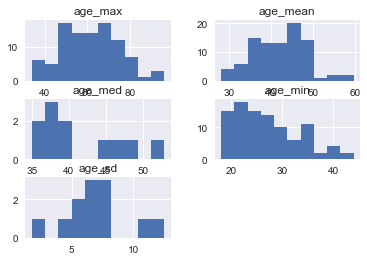

In [7]:
all_data[[c for c in all_data.columns if c.startswith('age')]].hist();

Breakdown on studies by design.

In [8]:
all_data.design.value_counts()

Retrospective    94
Prospective      40
RCT              27
Name: design, dtype: int64

Following [Pritts et al. (2015)](http://www.ncbi.nlm.nih.gov/pubmed/26283890), I fit a binomial random effects model, such that event probabilities on the logit scale are normally distributed with mean $\mu$ and standard deviation $\sigma$. This distribution describes how the probabilities vary across studies, with the degree of variation described by $\sigma$.

$$\theta_i \sim N(\mu, \sigma^2)$$

the expected value for study $i$ is then inverse-logit transformed, and used as the event probability $\pi_i$ in a binomial model describing the number of observed tumors $t$:

$$\log\left[\frac{\pi_i}{1-\pi_i}\right] = \theta_i$$

$$t_i \sim \text{Bin}(n_i, \pi_i)$$

There appears to be no obvious relationship between age (normalized) and tumor rate (though a quadratic model might be worth considering). We will not include age as a covariate in the model.

(0, 0.03)

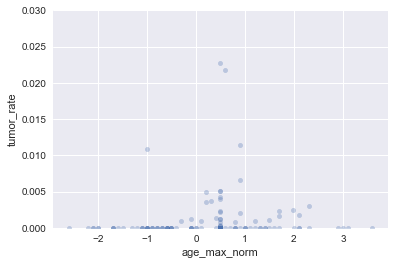

In [9]:
(all_data.assign(age_max_norm=((all_data.age_max - 60)/10).fillna(0.5), 
                 tumor_rate=all_data.Tumors/all_data.Population)
         .plot.scatter(x='age_max_norm', y='tumor_rate', style='ro', alpha=0.3)
         .set_ylim(0, 0.03))

## Age summarization

In [10]:
updated_pritts.groupby('Prospective').age_mean.mean()

Prospective
0    42.391667
1    38.493750
Name: age_mean, dtype: float64

In [11]:
updated_pritts.groupby('Prospective').age_mean.std()

Prospective
0    5.414867
1    6.339617
Name: age_mean, dtype: float64

In [12]:
all_data.groupby('Prospective').age_mean.mean()

Prospective
0    43.394921
1    38.475926
Name: age_mean, dtype: float64

In [13]:
all_data.groupby('Prospective').age_mean.std()

Prospective
0    5.594163
1    6.035098
Name: age_mean, dtype: float64

##  Recapitulation of Pritts original  Meta-analysis

Here we try to recreate the original Pritts model by exactly specifying the model as the original, and using the same dataset.

Here is the model:

In [14]:
import theano.tensor as tt
invlogit = pm.math.invlogit

def original_model(model_data):
    
    with pm.Model() as model:

        k = model_data.shape[0]
        tumors = model_data.Tumors.values.astype(int)
        n = model_data.Population.values.astype(int)

        # Study random effect
        μ = pm.Normal('μ', 0, sd=100)
        σ = pm.Uniform('σ', 0, 10)
        ζ = pm.Normal('ζ', 0, 1, shape=k)
        θ = μ + ζ*σ

        # Study-specific probabilities
        π = pm.Deterministic('π', invlogit(θ))

        # Expected probabilities by design
        p_10000 = pm.Deterministic('p_10000', invlogit(μ)*10000)

        obs = pm.Binomial('obs', n=n, p=π, observed=tumors)
        
    return model

In [15]:
prospective_mask = old_pritts.design=='Prospective'

pritts_prospective = original_model(old_pritts[prospective_mask])
pritts_retrospective = original_model(old_pritts[~prospective_mask])

In [16]:
iterations = 2000
tune = 3000

Here's the prospective model:

In [17]:
with pritts_prospective:
    prospective_trace = pm.sample(iterations, njobs=4, tune=tune, 
                                  random_seed=rseeds, nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 96%|█████████▌| 4793/5000 [01:19<00:03, 64.39it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 4980/5000 [01:21<00:00, 95.21it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5000/5000 [01:22<00:00, 88.49it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



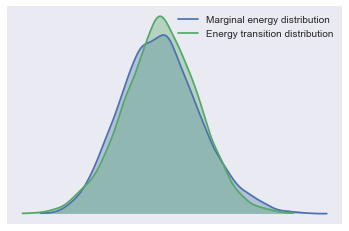

In [18]:
pm.energyplot(prospective_trace)

In [19]:
pm.summary(prospective_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,2.0512,3.3434,0.0583,0.0000,9.2662,3314.0,1.0007
μ,-11.4971,4.3495,0.0753,-20.5955,-6.2711,2475.0,1.0015
σ,3.3870,2.5455,0.0470,0.0010,8.6577,2258.0,1.0011


The following plots are the distribution of samples from the posterior distributions for the expected (population) probability of tumor (`p_update`), the inverse-logit expected probability ($\mu$) and the standard deviation of the probabilities on the inverse-logit scale ($\sigma$).

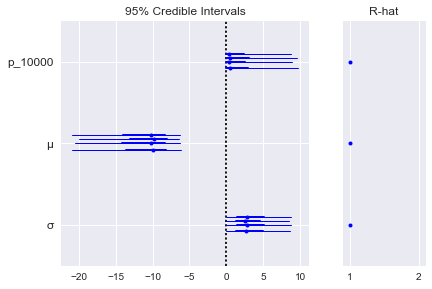

In [20]:
pm.forestplot(prospective_trace, varnames=['p_10000', 'μ', 'σ']);

Here's the retrospective model:

In [21]:
with pritts_retrospective:
    retrospective_trace = pm.sample(iterations, njobs=4, tune=tune, random_seed=rseeds, 
                                    nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 97%|█████████▋| 4857/5000 [00:33<00:00, 207.46it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 4 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 4998/5000 [00:33<00:00, 231.64it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5000/5000 [00:33<00:00, 147.41it/s]
/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 4 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


In [22]:
pm.summary(retrospective_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,5.0735,2.3279,0.0490,0.8434,9.5967,2208.0,0.9998
μ,-7.7089,0.5378,0.0136,-8.7342,-6.7475,1525.0,0.9999
σ,1.1657,0.4236,0.0109,0.3955,2.0000,1416.0,0.9998


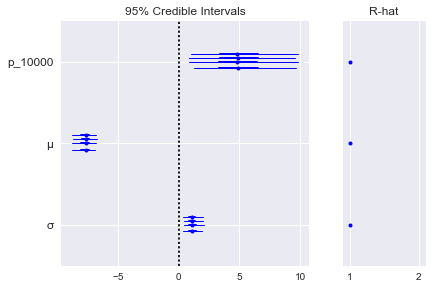

In [23]:
pm.forestplot(retrospective_trace, varnames=['p_10000', 'μ', 'σ']);

By comparison, estimates from Pritts' supplement:

![pritts estimates](pritts_table.png)

In [26]:
def pritts_plot(traces, title=''):
    
    intervals = [pm.stats.hpd(tr['p_10000']) for tr in traces]

    meds = [np.mean(tr['p_10000']) for tr in traces]
    upper = [i[1] - m for m,i in zip(meds, intervals)]
    lower = [m - i[0] for m,i in zip(meds, intervals)]

    plt.errorbar(np.arange(2)-0.1, meds, yerr=[lower, upper], fmt='s', label='Updated MA')
    plt.errorbar(np.arange(2)+0.1, [5.7, 1.2], yerr=[[5.7-1.7, 1.2], [11.3 - 5.7,7.5 - 1.2]], 
                 color='r', fmt='D', label='Pritts MA', elinewidth=0.5)
    plt.xticks(range(3), ['Retrospective', 'Prospective'])
    plt.ylabel('Rate per 10,000 surgeries')
    plt.xlim(-0.5, 1.5)
    plt.title(title)
    plt.legend();

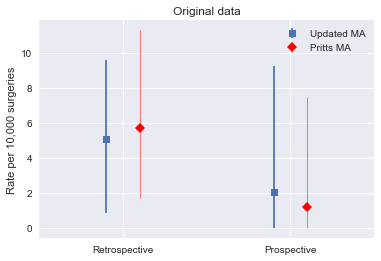

In [27]:
pritts_plot([retrospective_trace, prospective_trace], 'Original data')

## Pritts Update

This is the same Pritts model, but with updated data.

In [28]:
prospective_mask = updated_pritts.design=='Prospective'

pritts_updated_prosp = original_model(updated_pritts[prospective_mask])
pritts_updated_retro = original_model(updated_pritts[~prospective_mask])

In [29]:
updated_pritts[prospective_mask].Population.sum(), updated_pritts[prospective_mask].Population.shape[0]

(3648, 38)

In [30]:
updated_pritts[~prospective_mask].Population.sum(), updated_pritts[~prospective_mask].Population.shape[0]

(26504, 96)

In [31]:
updated_pritts.shape

(134, 18)

In [32]:
with pritts_updated_prosp:
    updated_prosp_trace = pm.sample(iterations, tune=tune, njobs=4, random_seed=rseeds, 
                                    nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 4991/5000 [01:38<00:00, 79.64it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5000/5000 [01:38<00:00, 50.85it/s]
/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 3 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


In [33]:
with pritts_updated_retro:
    updated_retro_trace = pm.sample(iterations, tune=tune, njobs=4, random_seed=rseeds, 
                                    nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 96%|█████████▌| 4795/5000 [00:30<00:00, 260.62it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5000/5000 [00:30<00:00, 163.06it/s]


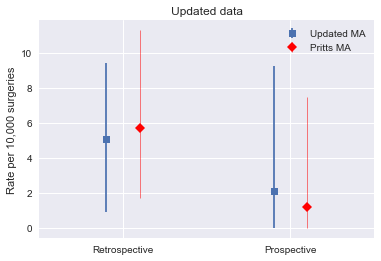

In [34]:
pritts_plot([updated_retro_trace, updated_prosp_trace], 'Updated data')

### Prospective estimates

In [35]:
pm.summary(updated_prosp_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,2.0840,3.4088,0.0573,0.0000,9.2599,3152.0,0.9998
μ,-11.5365,4.3977,0.0860,-20.6248,-6.1089,2061.0,1.0000
σ,3.4008,2.5531,0.0539,0.0001,8.6048,1884.0,1.0002


### Retrospective estimates

In [36]:
pm.summary(updated_retro_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,5.0858,2.2814,0.0478,0.9240,9.4244,1992.0,0.9999
μ,-7.6995,0.5178,0.0113,-8.7607,-6.8218,1710.0,1.0000
σ,1.1595,0.4053,0.0095,0.4417,1.9655,1606.0,0.9999


## Pritts update with EPC includes

In [37]:
prospective_mask = all_data.design=='Prospective'

pritts_epc_prospective = original_model(all_data[prospective_mask])
pritts_epc_retrospective = original_model(all_data[~prospective_mask])

In [38]:
all_data[prospective_mask].Population.sum(), all_data[prospective_mask].Population.shape[0]

(3673, 40)

In [39]:
all_data[~prospective_mask].Population.sum(), all_data[~prospective_mask].Population.shape[0]

(127907, 121)

In [40]:
all_data.shape

(161, 18)

In [41]:
with pritts_epc_retrospective:
    epc_retrospective_trace = pm.sample(iterations, tune=tune, njobs=4, random_seed=rseeds, 
                                    nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5000/5000 [00:55<00:00, 90.19it/s] 
/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


In [42]:
with pritts_epc_prospective:
    epc_prospective_trace = pm.sample(iterations, tune=tune, njobs=4, random_seed=rseeds, 
                                    nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 4968/5000 [01:34<00:00, 57.69it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 2 does not match the target. It is 0.766221309231, but should be close to 0.9. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 49 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 4995/5000 [01:34<00:00, 58.58it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.821708450588, but should be close to 0.9. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/fonnescj/Rep

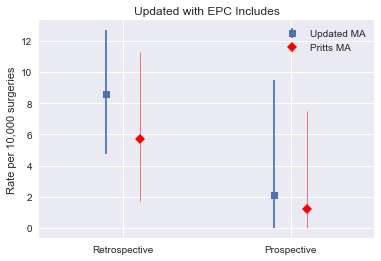

In [43]:
pritts_plot([epc_retrospective_trace, epc_prospective_trace], 'Updated with EPC Includes')

### Prospective estimates

In [44]:
pm.summary(epc_prospective_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,2.0952,3.3960,0.0548,0.0000,9.4616,3392.0,1.0005
μ,-11.5384,4.4344,0.0852,-21.0328,-6.1916,2175.0,1.0001
σ,3.3701,2.5463,0.0495,0.0005,8.5815,2122.0,1.0003


### Retrospective estimates

In [45]:
pm.summary(epc_retrospective_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,8.5961,2.0419,0.0376,4.7202,12.6752,3009.0,0.9998
μ,-7.0878,0.2495,0.0048,-7.5820,-6.6193,2730.0,0.9998
σ,1.0992,0.1910,0.0033,0.7597,1.4826,2689.0,1.0000


## No hysteroscopy subset

Remove studies that used hysteroscopy

In [46]:
all_data.Hysteroscopy.value_counts()

no     125
yes     36
Name: Hysteroscopy, dtype: int64

In [47]:
hysteroscopy_mask = all_data.Hysteroscopy=='no'

all_data[prospective_mask & hysteroscopy_mask].shape

(28, 18)

In [48]:
all_data[(~prospective_mask) & hysteroscopy_mask].shape

(97, 18)

In [49]:
no_hysteroscopy_prospective = original_model(all_data[prospective_mask & hysteroscopy_mask])
no_hysteroscopy_retrospective = original_model(all_data[(~prospective_mask) & hysteroscopy_mask])

In [50]:
all_data.pivot_table(index='Prospective', columns='Hysteroscopy', values='Tumors').round(2)

Hysteroscopy,no,yes
Prospective,,
0,2.72,4.50
1,0.00,0.21


In [51]:
with no_hysteroscopy_retrospective:
    hyst_retrospective_trace = pm.sample(iterations, njobs=4, tune=tune, random_seed=rseeds, 
                                    nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5000/5000 [00:52<00:00, 95.43it/s] 
/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


### Retrospective estimates

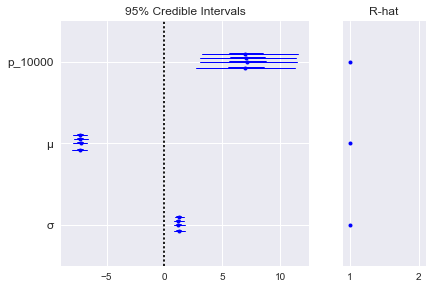

In [53]:
pm.forestplot(hyst_retrospective_trace, varnames=['p_10000', 'μ', 'σ'])

In [54]:
pm.summary(hyst_retrospective_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,7.2161,2.2024,0.0421,3.0887,11.4843,2613.0,1.0008
μ,-7.2824,0.3222,0.0064,-7.9291,-6.6961,2499.0,1.0011
σ,1.2568,0.2398,0.0047,0.8286,1.7395,2781.0,1.0009


In [55]:
with no_hysteroscopy_prospective:
    hyst_prospective_trace = pm.sample(iterations, njobs=4, tune=tune, random_seed=rseeds, 
                                    nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 91%|█████████▏| 4573/5000 [02:45<00:15, 27.29it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 51 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 97%|█████████▋| 4837/5000 [02:52<00:04, 39.27it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 34 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 4996/5000 [02:56<00:00, 38.40it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 4 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Ch

Note that there were no tumors in this subset.

In [56]:
all_data.loc[prospective_mask & hysteroscopy_mask, ['Tumors', 'Population']]

,Tumors,Population
Line,,
2.0,0,10
6.0,0,91
9.0,0,24
14.0,0,136
15.0,0,11
21.0,0,9
27.0,0,213
31.0,0,17
44.0,0,47


### Prospective estimates

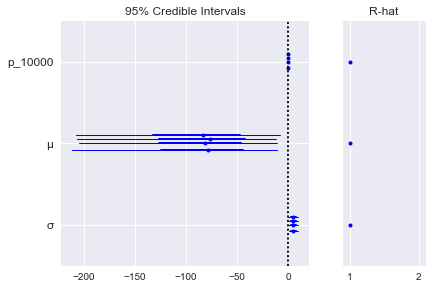

In [57]:
pm.forestplot(hyst_prospective_trace, varnames=['p_10000', 'μ', 'σ'])

In [58]:
pm.summary(hyst_prospective_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,0.0058,0.1319,0.0015,0.0000,0.0000,8000.0,1.0001
μ,-91.9598,59.3928,0.9833,-207.3655,-10.3243,2900.0,1.0004
σ,4.8702,2.8383,0.0285,0.1245,9.5018,8000.0,0.9998


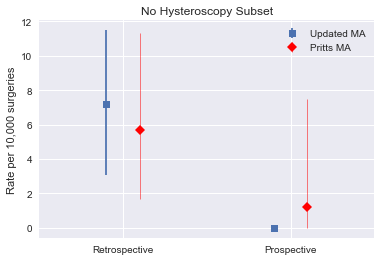

In [59]:
pritts_plot([hyst_retrospective_trace, hyst_prospective_trace], 'No Hysteroscopy Subset')

## Confirmed histopathology subset

Include only studies that had post-surgical histopathology

In [60]:
all_data.POSTOP_HP_Done.value_counts()

yes        144
unclear     16
NO           1
Name: POSTOP_HP_Done, dtype: int64

In [61]:
histopath_mask = all_data.POSTOP_HP_Done=='yes'

all_data[prospective_mask & histopath_mask].shape

(36, 18)

In [62]:
all_data[(~prospective_mask) & histopath_mask].shape

(108, 18)

In [63]:
histo_prospective = original_model(all_data[prospective_mask & histopath_mask])
histo_retrospective = original_model(all_data[(~prospective_mask) & histopath_mask])

In [64]:
with histo_retrospective:
    histo_retrospective_trace = pm.sample(iterations, njobs=4, tune=tune, random_seed=rseeds, 
                                    nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 4950/5000 [01:01<00:00, 109.70it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5000/5000 [01:01<00:00, 81.33it/s] 


### Retrospective estimates

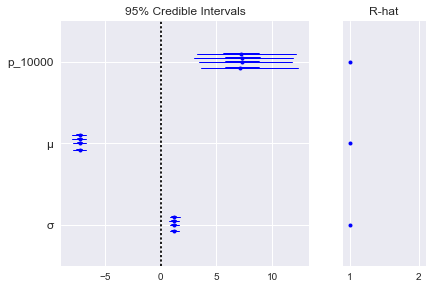

In [65]:
pm.forestplot(histo_retrospective_trace, varnames=['p_10000', 'μ', 'σ'])

In [66]:
pm.summary(histo_retrospective_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,7.4262,2.2649,0.0388,3.4115,12.1565,2979.0,1.0000
μ,-7.2534,0.3209,0.0058,-7.8511,-6.6170,2819.0,1.0002
σ,1.2230,0.2325,0.0038,0.7998,1.6848,2804.0,0.9999


In [67]:
with histo_prospective:
    histo_prospective_trace = pm.sample(iterations, njobs=4, tune=tune, random_seed=rseeds, 
                                    nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5000/5000 [01:30<00:00, 55.06it/s]


### Prospective estimates

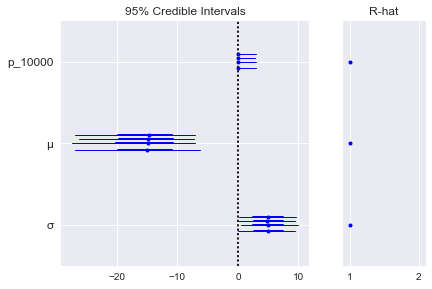

In [68]:
pm.forestplot(histo_prospective_trace, varnames=['p_10000', 'μ', 'σ'])

In [69]:
pm.summary(histo_prospective_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,0.4890,1.4610,0.0200,0.0000,2.9297,4626.0,1.0001
μ,-15.8199,5.9658,0.1020,-26.8430,-6.7955,3702.0,0.9999
σ,4.9734,2.8448,0.0464,0.2214,9.6593,3375.0,0.9998


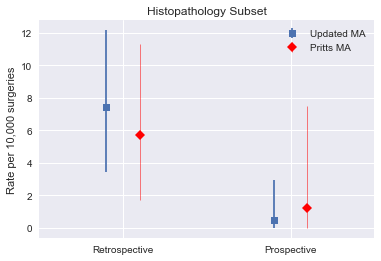

In [70]:
pritts_plot([histo_retrospective_trace, histo_prospective_trace], 'Histopathology Subset')

### Goodness of fit

To check how well the model fits the data, I conducted posteior predictive checks. This simulates data from the model for each data point (*i.e.* study) in the meta-analysis, and compares the distribution of these simulated values (here, 500 replicates) with the value of the data itself. If the percentile of the datum is very extreme (either large or small), then it is evidence that the model does not adequately fit the data. The distribution of percentiles in the bottom histogram shows that there is no evidence of lack of fit.

In [71]:
ppc_retro = pm.sample_ppc(epc_retrospective_trace, model=pritts_epc_retrospective, samples=500)
ppc_prosp = pm.sample_ppc(epc_prospective_trace, model=pritts_epc_prospective, samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]


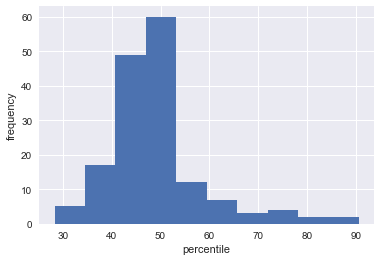

In [72]:
from scipy.stats import percentileofscore
        
p = [percentileofscore(s, o).round(2) for s,o in zip(ppc_retro['obs'].T, all_data[~prospective_mask].Tumors)]
p += [percentileofscore(s, o).round(2) for s,o in zip(ppc_prosp['obs'].T, all_data[prospective_mask].Tumors)]
        
plt.hist(p)
plt.xlabel('percentile')
plt.ylabel('frequency');

## Combined models

Additional model runs that pool retrospective and prospective designs.

First, the original Pritts data:

In [73]:
with original_model(old_pritts) as pritts_pooled:
    pooled_trace = pm.sample(iterations, njobs=4, tune=tune, 
                                  random_seed=rseeds)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 97%|█████████▋| 4863/5000 [00:37<00:00, 200.29it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 4992/5000 [00:38<00:00, 179.36it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5000/5000 [00:38<00:00, 129.54it/s]
/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 12 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning:

In [74]:
pm.summary(pooled_trace, varnames=['p_10000', 'μ', 'σ']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_10000,5.0390,2.1492,0.0369,1.1564,9.1893,3161.0,1.0005
μ,-7.6942,0.4756,0.0095,-8.6665,-6.8392,2207.0,1.0009
σ,1.1231,0.3682,0.0079,0.4620,1.8613,1832.0,1.0009


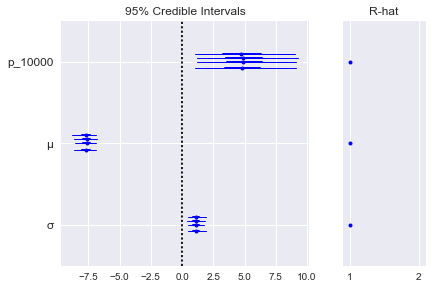

In [75]:
pm.forestplot(pooled_trace, varnames=['p_10000', 'μ', 'σ']);

Updated Pritts data:

In [76]:
with original_model(updated_pritts) as updated_pooled:
    updated_pooled_trace = pm.sample(iterations, njobs=4, tune=tune, 
                                  random_seed=rseeds, nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 4977/5000 [00:38<00:00, 208.66it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5000/5000 [00:38<00:00, 130.67it/s]


In [77]:
pm.summary(updated_pooled_trace[-keep:], varnames=['p_10000', 'μ', 'σ']).round(4)

NameError: name 'keep' is not defined

In [ ]:
pm.forestplot(updated_pooled_trace[-keep:], varnames=['p_10000', 'μ', 'σ']);

Updated Pritts data with EPC includes:

In [ ]:
with original_model(all_data) as all_pooled:
    all_pooled_trace = pm.sample(iterations, njobs=4, tune=tune, 
                                  random_seed=rseeds, nuts_kwargs={'target_accept': 0.9})

In [ ]:
pm.summary(all_pooled_trace[-keep:], varnames=['p_10000', 'μ', 'σ']).round(4)

In [ ]:
pm.forestplot(all_pooled_trace[-keep:], varnames=['p_10000', 'μ', 'σ']);

No hysteroscopy subset

In [ ]:
with original_model(all_data[hysteroscopy_mask]) as no_hyst:
    no_hyst_trace = pm.sample(iterations, njobs=4, tune=tune, 
                                  random_seed=rseeds, nuts_kwargs={'target_accept': 0.9})

In [ ]:
pm.summary(no_hyst_trace[-keep:], varnames=['p_10000', 'μ', 'σ']).round(4)

In [ ]:
pm.forestplot(no_hyst_trace[-keep:], varnames=['p_10000', 'μ', 'σ']);

Histopathology subset

In [ ]:
with original_model(all_data[histopath_mask]) as histopath:
    histopath_trace = pm.sample(iterations, njobs=4, tune=tune, 
                                  random_seed=rseeds, nuts_kwargs={'target_accept': 0.9})

In [ ]:
pm.summary(histopath_trace[-keep:], varnames=['p_10000', 'μ', 'σ']).round(4)

In [ ]:
pm.forestplot(histopath_trace[-keep:], varnames=['p_10000', 'μ', 'σ']);